In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def gen_data(size=100000):
    """
    生成数据:
        输入数据X：在时间t，Xt的值有50%的概率为1，50%的概率为0；
        输出数据Y：在实践t，Yt的值有50%的概率为1，50%的概率为0，除此之外，如果`Xt-3 == 1`，Yt为1的概率增加50%， 如果`Xt-8 == 1`，则Yt为1的概率减少25%， 如果上述两个条件同时满足，则Yt为1的概率为75%。
    """
    X = np.random.choice(2,(size,))
    Y = []
    for i in range(size):
        threshold = 0.5
        # 判断X[i-3]和X[i-8]是否为1，修改阈值
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        # 生成随机数，以threshold为阈值给Yi赋值
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X,np.array(Y)

In [4]:
def gen_batch(raw_data, batch_size, num_steps):
    # raw_data是使用gen_data()函数生成的数据，分别是X和Y
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    # 首先将数据切分成batch_size份，0-batch_size，batch_size-2*batch_size。。。
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    
    # 因为RNN模型一次只处理num_steps个数据，所以将每个batch_size在进行切分成epoch_size份，每份num_steps个数据。注意这里的epoch_size和模型训练过程中的epoch不同。
    for i in range(batch_size):
        data_x[i] = raw_x[i * batch_partition_length:(i + 1) * batch_partition_length]
        data_y[i] = raw_x[i * batch_partition_length:(i + 1) * batch_partition_length]
        
    # x是0-num_steps， batch_partition_length -batch_partition_length +num_steps。。。共batch_size个
    epoch_size = batch_partition_length // num_steps
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_x[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

In [5]:
def gen_epochs(n, num_steps):
    '''这里的n就是训练过程中用的epoch，即在样本规模上循环的次数'''
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps=num_steps)


W0815 13:59:50.105675 139691886995264 deprecation.py:323] From <ipython-input-6-938f039f2ac0>:20: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
W0815 13:59:50.107444 139691886995264 deprecation.py:323] From <ipython-input-6-938f039f2ac0>:21: static_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
W0815 13:59:50.110475 139691886995264 deprecation.py:323] From /usr/local/python3/lib/python3.6/site-packages/tensorflow_core/python/ops/rnn_cell_impl.py:455: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` met

\EPOCH 0
Average loss at step 100 for last 100 steps: 0.45625598669052125
Average loss at step 200 for last 100 steps: 0.33522686779499056
Average loss at step 300 for last 100 steps: 0.32363319605588914
Average loss at step 400 for last 100 steps: 0.3198443701863289
Average loss at step 500 for last 100 steps: 0.31799371004104615
Average loss at step 600 for last 100 steps: 0.316926654279232
Average loss at step 700 for last 100 steps: 0.3162370014190674
Average loss at step 800 for last 100 steps: 0.3157545381784439
Average loss at step 900 for last 100 steps: 0.31540178656578066
Average loss at step 1000 for last 100 steps: 0.3151378232240677
Average loss at step 1100 for last 100 steps: 0.31492061764001844
Average loss at step 1200 for last 100 steps: 0.314748175740242
Average loss at step 1300 for last 100 steps: 0.3146084254980087
Average loss at step 1400 for last 100 steps: 0.3144863533973694
Average loss at step 1500 for last 100 steps: 0.3143901726603508
Average loss at step 

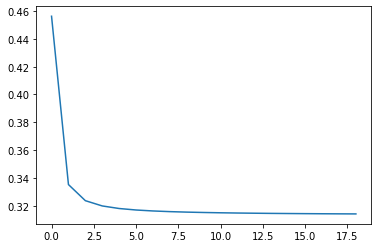

In [6]:
batch_size = 5
num_steps = 10
state_size = 10
n_classes = 2
learning_rate = 0.1

x = tf.placeholder(tf.int32, [batch_size, num_steps])
y = tf.placeholder(tf.int32, [batch_size, num_steps])

#RNN的初始化状态，全设为零。注意state是与input保持一致，接下来会有concat操作，所以这里要有batch的维度。即每个样本都要有隐层状态
init_state = tf.zeros([batch_size, state_size])

#将输入转化为one-hot编码，两个类别。[batch_size, num_steps, num_classes]
x_one_hot = tf.one_hot(x, n_classes)

#将输入unstack，即在num_steps上解绑，方便给每个循环单元输入。这里可以看出RNN每个cell都处理一个batch的输入（即batch个二进制样本输入）
rnn_inputs = tf.unstack(x_one_hot, axis=1)

#定义rnn_cell的权重参数，
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

# 定义softmax层
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, n_classes])
    b = tf.get_variable('b', [n_classes])

#注意，这里要将num_steps个输出全部分别进行计算其输出，然后使用softmax预测
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# tf.stack（）这是一个矩阵拼接的函数，tf.unstack（）则是一个矩阵分解的函数
y_as_lists = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for label, logit in zip(y_as_lists, predictions)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(total_loss)

def train_network(num_epochs, num_steps, state_size, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            # 保存每次执行后的最后状态，然后赋给下一次执行
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print('\EPOCH', idx)
            
            # 这是具体获得数据的部分
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = sess.run([losses, total_loss, final_state, train_step], 
                                                                        feed_dict={x:X, y:Y, init_state: training_state})
                
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,"for last 100 steps:", training_loss / 100)
                    
                    training_losses.append(training_loss / 100)
                    training_loss = 0
            
            return training_losses

training_losses = train_network(1, num_steps, state_size)
plt.plot(training_losses)
plt.show()